## **Processed Data**

In [76]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import m_eda_plots as edap
import m_metrics_plots as metp

plt.style.use('bmh')
plt.rcParams['font.size'] = 10


In [77]:
# import preprocessed data
PATH = 'processed_data/df_0.csv'
df = pd.read_csv(PATH)
size = os.path.getsize(PATH)

print('Data: df_01.csv')
print(f'{df.shape[0]} rows and {df.shape[1]} columns')
print(f'{size} bytes')

Data: df_01.csv
4476713 rows and 21 columns
455567959 bytes


In [78]:
df.head()

,client_id,creation_date,district,region,client_catg,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,1994-12-31,60,101,11,0.0,2014-03-24,11,1335667,0,...,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,1994-12-31,60,101,11,0.0,2013-03-29,11,1335667,0,...,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,1994-12-31,60,101,11,0.0,2015-03-23,11,1335667,0,...,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,1994-12-31,60,101,11,0.0,2015-07-13,11,1335667,0,...,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,1994-12-31,60,101,11,0.0,2016-11-17,11,1335667,0,...,9,1,572,0,0,0,15066,15638,12,ELEC


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476713 entries, 0 to 4476712
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   client_id             object 
 1   creation_date         object 
 2   district              int64  
 3   region                int64  
 4   client_catg           int64  
 5   target                float64
 6   invoice_date          object 
 7   tarif_type            int64  
 8   counter_number        int64  
 9   counter_statue        int64  
 10  counter_code          int64  
 11  reading_remarque      int64  
 12  counter_coefficient   int64  
 13  consommation_level_1  int64  
 14  consommation_level_2  int64  
 15  consommation_level_3  int64  
 16  consommation_level_4  int64  
 17  old_index             int64  
 18  new_index             int64  
 19  months_number         int64  
 20  counter_type          object 
dtypes: float64(1), int64(16), object(4)
memory usage: 717.2+ MB


# **Baseline Model LGBM**

### **categorical features**

In [80]:
# map the counter_type to integer
df['counter_type'] = df['counter_type'].map({'ELEC': 0, 'GAZ': 1})

# transform the type of categorical variables
cat_fs = ['district', 'client_catg', 'region', 'counter_type']
df[cat_fs] = df[cat_fs].astype('category')

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476713 entries, 0 to 4476712
Data columns (total 21 columns):
 #   Column                Dtype   
---  ------                -----   
 0   client_id             object  
 1   creation_date         object  
 2   district              category
 3   region                category
 4   client_catg           category
 5   target                float64 
 6   invoice_date          object  
 7   tarif_type            int64   
 8   counter_number        int64   
 9   counter_statue        int64   
 10  counter_code          int64   
 11  reading_remarque      int64   
 12  counter_coefficient   int64   
 13  consommation_level_1  int64   
 14  consommation_level_2  int64   
 15  consommation_level_3  int64   
 16  consommation_level_4  int64   
 17  old_index             int64   
 18  new_index             int64   
 19  months_number         int64   
 20  counter_type          category
dtypes: category(4), float64(1), int64(13), object(3)
memor

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

SEED = 2004

# features to drop
drop_fs = ['client_id', 'creation_date', 'invoice_date', 'target']

# set up X and y
y = df['target']
X = df.drop(drop_fs, axis=1)

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3581370, 17), (895343, 17), (3581370,), (895343,))

------- Model: Baseline_GBM -------
ROC AUC:  0.6980177667661647
Classification Report: 
               precision    recall  f1-score   support

         0.0      0.953     0.655     0.777    824806
         1.0      0.134     0.625     0.221     70537

    accuracy                          0.653    895343
   macro avg      0.544     0.640     0.499    895343
weighted avg      0.889     0.653     0.733    895343

Confusion Matrix: 
 [[540614 284192]
 [ 26483  44054]]
Confusion Matrix (Normalized): 
 [[0.65544383 0.34455617]
 [0.37544835 0.62455165]]


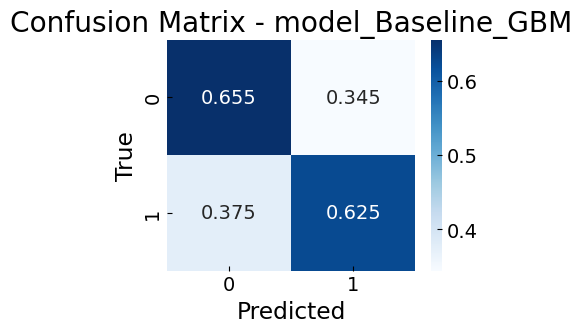

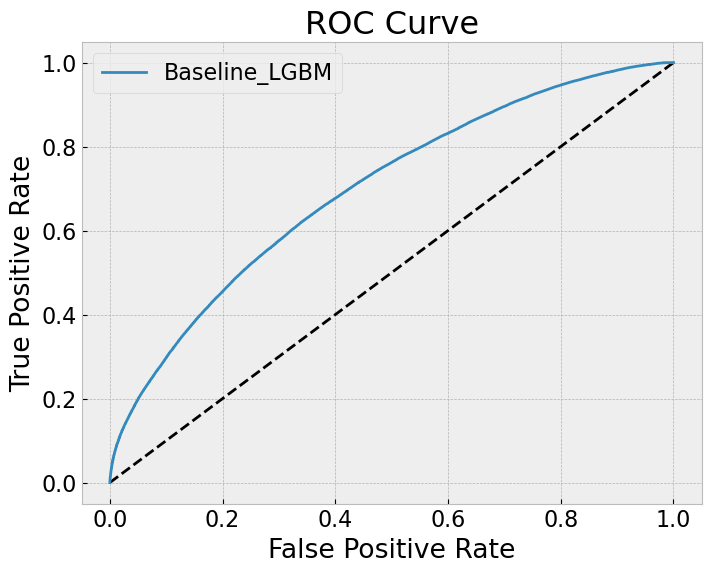

In [83]:
from lightgbm import LGBMClassifier

# list to store data for ROC curves
roc_curve_list = []

# baseline model
# the original dataset is imbalanced, so I use the class_weight='balanced' to balance the classes
lgbm = LGBMClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=SEED, verbose=-1)
lgbm.fit(X_train, y_train, categorical_feature=cat_fs)

# predict on test data
y_pred = lgbm.predict(X_test)  
y_pred_proba = lgbm.predict_proba(X_test)[:,1]

# append the data to the list
roc_curve_list += [('Baseline_LGBM', y_test, y_pred, y_pred_proba)]
# calculate the metrics and plot the confusion matrix
metp.scores_and_matrix('Baseline_GBM', y_test, y_pred, y_pred_proba)
# plot the ROC curve
metp.all_roc_curves(roc_curve_list)

# **Model_LGBM_1**

## **Create new features**

### **creation_date, invoice_date**

In [84]:
# transform date column to datetime format
date = ['creation_date', 'invoice_date']
for col in date:
    df[col] = pd.to_datetime(df[col])
    print(f'Type of {col}: {df[col].dtype}')

Type of creation_date: datetime64[ns]
Type of invoice_date: datetime64[ns]


### **before**

In [85]:
# create a new categorical feature: if the invoice is issued before the creation date
df['before'] = df['creation_date'] > df['invoice_date']

# transform the boolean feature to integer
df['before'] = df['before'].astype(int)
df['before'].value_counts()


before
0    4462952
1      13761
Name: count, dtype: int64

### **year, month**

In [86]:
# add new features year and month
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month
df.year.dtype, df.month.dtype


(dtype('int32'), dtype('int32'))

The table means the number and the ratio of non-fraudulent and fraudulent cases for each feature value.
target     0.0    1.0   ratio_0   ratio_1
year                                     
2005     60270   4392  0.932078  0.067922
2006    204340  17430  0.921405  0.078595
2007    227006  19178  0.922099  0.077901
2008    242532  20681  0.921429  0.078571
2009    261578  22797  0.919835  0.080165
2010    290379  25850  0.918255  0.081745
2011    285177  25225  0.918734  0.081266
2012    295390  26721  0.917044  0.082956
2013    308067  27877  0.917019  0.082981
2014    315102  28272  0.917664  0.082336
2015    331561  29198  0.919065  0.080935
2016    353686  29966  0.921893  0.078107
2017    378778  32153  0.921756  0.078244
2018    311177  24465  0.927110  0.072890
2019    236446  18907  0.925957  0.074043



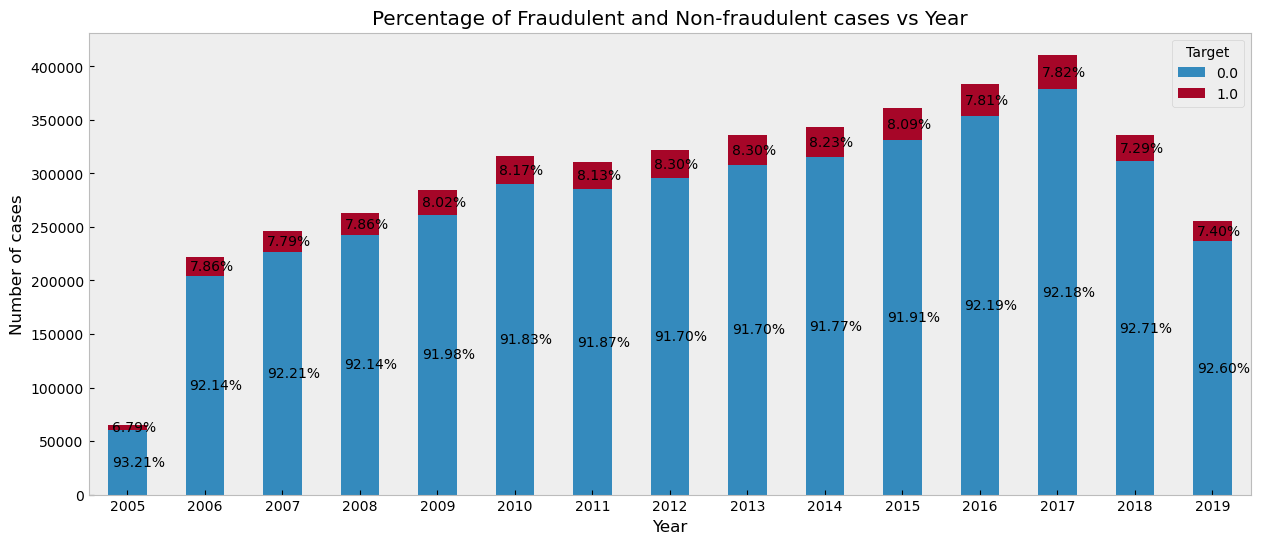

The highest rate of fraudulent is year = 2013 with rate 8.30%
The second highest rate of fraudulent is tarif_type = 2012 with rate 8.30%
The third highest rate of fraudulent is tarif_type = 2014 with rate 8.23%


In [87]:
plt.style.use('bmh')
plt.rcParams['font.size'] = 10

# plot Percentage of Fraudulent and Non-Fraudulent Cases Over Year
edap.feature_target_distribution(df[df['year']>=2005], 'year', 'target')


The table means the number and the ratio of non-fraudulent and fraudulent cases for each feature value.
target     0.0    1.0   ratio_0   ratio_1
month                                    
1       348672  31680  0.916709  0.083291
2       379462  37992  0.908991  0.091009
3       369637  32372  0.919474  0.080526
4       376253  32930  0.919523  0.080477
5       385084  33803  0.919303  0.080697
6       338862  27981  0.923725  0.076275
7       329546  25320  0.928649  0.071351
8       326652  26096  0.926021  0.073979
9       309395  27237  0.919090  0.080910
10      321399  26790  0.923059  0.076941
11      333315  26402  0.926603  0.073397
12      305324  24509  0.925693  0.074307



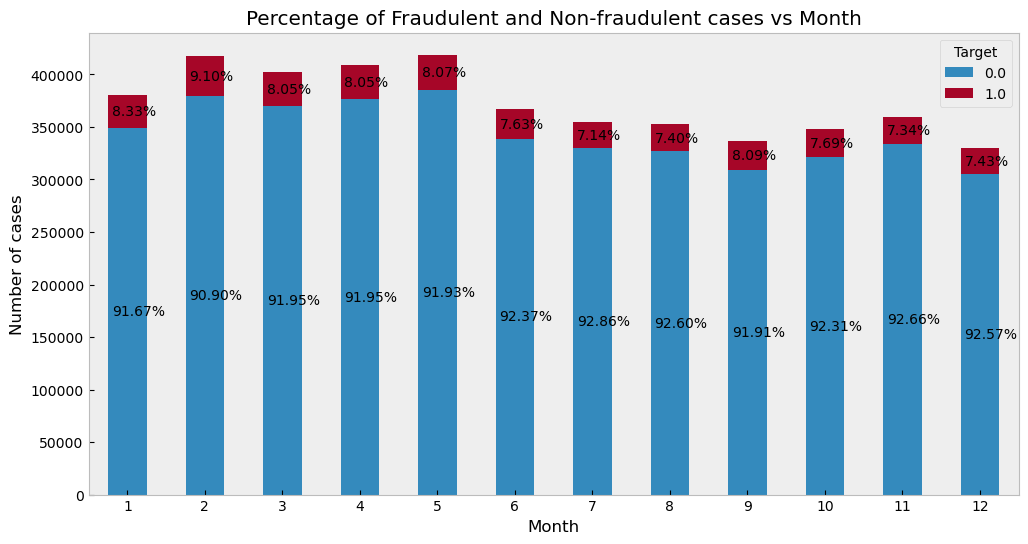

The highest rate of fraudulent is month = 2 with rate 9.10%
The second highest rate of fraudulent is tarif_type = 1 with rate 8.33%
The third highest rate of fraudulent is tarif_type = 9 with rate 8.09%


In [88]:
# plot Percentage of Fraudulent and Non-Fraudulent Cases Over Month
edap.feature_target_distribution(df, 'month', 'target')

### **numerical features**

### **consumption, consumption_per_month, index_interval, index_interval_per_month**

In [89]:
# sum up the consumption of all levels
df['consumption'] = df['consommation_level_1'] + df['consommation_level_2'] + df['consommation_level_3'] + df['consommation_level_4']

# calculate the interval between the old and new index
df['index_interval'] = df['new_index'] - df['old_index']

# divide the consumption by the number of months
df['consumption_per_month'] = df['consumption'] / df['months_number'] 

# divide the interval by the number of months
df['index_interval_per_month'] = df['index_interval'] / df['months_number'] 

### **diff**

In [90]:
# create a new feature: if 'counter_coefficient * index_interval != consumption'
df['diff'] = df['counter_coefficient'] * df['index_interval'] != df['consumption']
# transform boolean to integer
df['diff'] = df['diff'].astype(int)

### **counter_code, uniq_counter**

In [91]:
# inspect how many unique counter_code in each client_id
df.query('client_id == "train_Client_100083"')[['counter_code', 'target']].nunique()

counter_code    3
target          1
dtype: int64

In [92]:
# create a new column to record the number of unique counter_code in each client_id
df['uniq_counter'] = df.groupby('client_id')['counter_code'].transform('nunique')
# check if the new column is correct
print(df.query('client_id == "train_Client_100083"').uniq_counter[:1])


2977    3
Name: uniq_counter, dtype: int64


The table means the number and the ratio of non-fraudulent and fraudulent cases for each feature value.
target          0.0   1.0   ratio_0   ratio_1
uniq_counter                                 
1.0           67034  2322  0.966521  0.033479
2.0           55675  4058  0.932064  0.067936
3.0            4796  1056  0.819549  0.180451
4.0             392   120  0.765625  0.234375
5.0              24     8  0.750000  0.250000
6.0               5     2  0.714286  0.285714



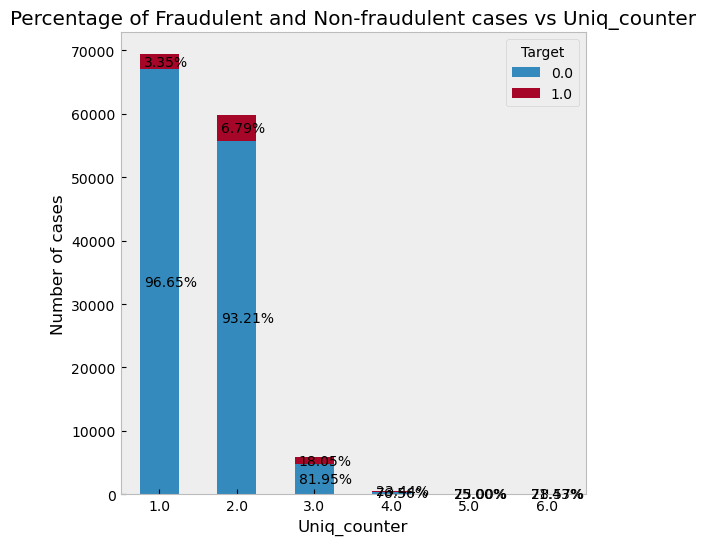

The highest rate of fraudulent is uniq_counter = 6.0 with rate 28.57%
The second highest rate of fraudulent is tarif_type = 5.0 with rate 25.00%
The third highest rate of fraudulent is tarif_type = 4.0 with rate 23.44%


In [93]:
# plot distribution of target cases vs uniq_counter
agg_df = df.groupby('client_id')[['uniq_counter', 'target']].mean()

# plot distribution of target cases vs uniq_counter
edap.feature_target_distribution(agg_df, 'uniq_counter', 'target')

In [94]:
# check if there is any NaN value
df.isnull().sum()

client_id                   0
creation_date               0
district                    0
region                      0
client_catg                 0
target                      0
invoice_date                0
tarif_type                  0
counter_number              0
counter_statue              0
counter_code                0
reading_remarque            0
counter_coefficient         0
consommation_level_1        0
consommation_level_2        0
consommation_level_3        0
consommation_level_4        0
old_index                   0
new_index                   0
months_number               0
counter_type                0
before                      0
year                        0
month                       0
consumption                 0
index_interval              0
consumption_per_month       0
index_interval_per_month    2
diff                        0
uniq_counter                0
dtype: int64

In [95]:
# Selecting numeric columns
num_fs = [f for f in df.columns if df[f].dtype in ['int64', 'float64']]

# Checking for infinite values
np.isinf(df[num_fs]).sum()


target                      0
tarif_type                  0
counter_number              0
counter_statue              0
counter_code                0
reading_remarque            0
counter_coefficient         0
consommation_level_1        0
consommation_level_2        0
consommation_level_3        0
consommation_level_4        0
old_index                   0
new_index                   0
months_number               0
before                      0
consumption                 0
index_interval              0
consumption_per_month       2
index_interval_per_month    0
diff                        0
uniq_counter                0
dtype: int64

In [96]:
# take a look of the rows with months_number == 0
df.query('months_number == 0').head()

,client_id,creation_date,district,region,client_catg,target,invoice_date,tarif_type,counter_number,counter_statue,...,counter_type,before,year,month,consumption,index_interval,consumption_per_month,index_interval_per_month,diff,uniq_counter
3704403,train_Client_79075,2011-11-28,69,107,11,0.0,2012-01-16,40,412,9,...,1,0,2012,1,1,0,inf,NaN,1,3
3985931,train_Client_86638,2009-10-12,69,104,11,0.0,2010-05-04,40,128190,0,...,1,0,2010,5,1,0,inf,NaN,1,2


In [97]:
# check how many rows the clients train_Client_79075 have
df.query('client_id == "train_Client_79075"').shape

(19, 30)

In [98]:
# checkhow many rows the client train_Client_79075 have
df.query('client_id == "train_Client_79075"').months_number.value_counts()

months_number
4    13
2     4
8     1
0     1
Name: count, dtype: int64

In [99]:
# drop the rows with months_number == 0
#df = df[df.months_number != 0]


### **New DataFrame** - after create some features

In [100]:
# a new dataframe for BaseLine Model
df.to_csv('processed_data/df_1_uniq_code.csv', index=False)

In [101]:
import pandas as pd
import numpy as np

df = pd.read_csv('processed_data/df_1_uniq_code.csv')
df.shape, df.columns

((4476713, 30),
 Index(['client_id', 'creation_date', 'district', 'region', 'client_catg',
        'target', 'invoice_date', 'tarif_type', 'counter_number',
        'counter_statue', 'counter_code', 'reading_remarque',
        'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
        'consommation_level_3', 'consommation_level_4', 'old_index',
        'new_index', 'months_number', 'counter_type', 'before', 'year', 'month',
        'consumption', 'index_interval', 'consumption_per_month',
        'index_interval_per_month', 'diff', 'uniq_counter'],
       dtype='object'))

### **Modeling**

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

SEED = 2004

# features to drop
drop_fs = ['client_id', 'creation_date', 'invoice_date', 'target']

# set up X and y
y = df['target']
X = df.drop(drop_fs, axis=1)

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3581370, 26), (895343, 26), (3581370,), (895343,))

------- Model: LGBM_1 -------
ROC AUC:  0.7326540209678967
Classification Report: 
               precision    recall  f1-score   support

         0.0      0.957     0.700     0.809    824806
         1.0      0.153     0.633     0.246     70537

    accuracy                          0.695    895343
   macro avg      0.555     0.666     0.528    895343
weighted avg      0.894     0.695     0.764    895343

Confusion Matrix: 
 [[577599 247207]
 [ 25914  44623]]
Confusion Matrix (Normalized): 
 [[0.70028467 0.29971533]
 [0.36738166 0.63261834]]


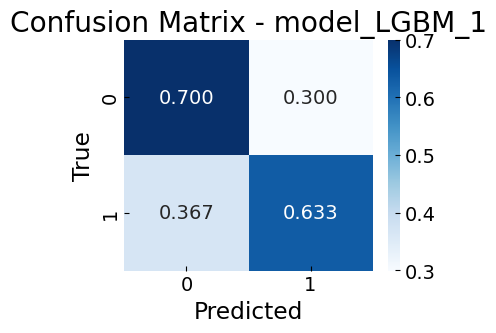

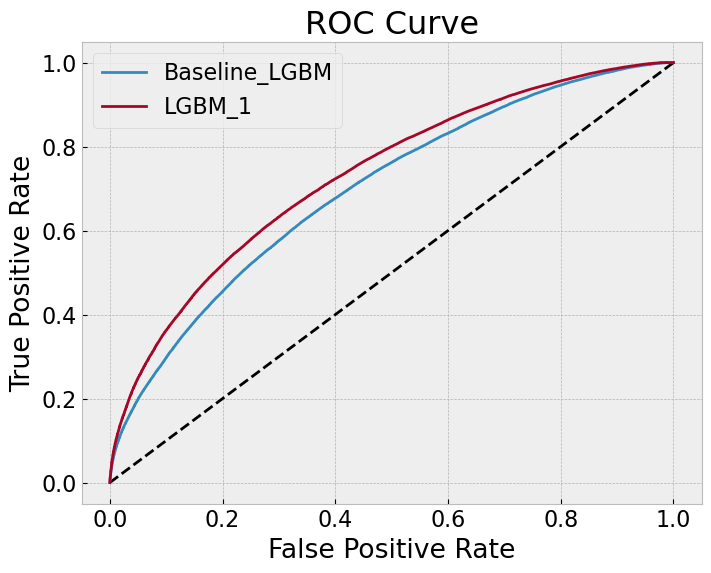

In [103]:
lgbm = LGBMClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=SEED, verbose=-1)
lgbm.fit(X_train, y_train, categorical_feature=cat_fs)

y_pred = lgbm.predict(X_test)  
y_pred_proba = lgbm.predict_proba(X_test)[:,1]

roc_curve_list += [('LGBM_1', y_test, y_pred, y_pred_proba)]
metp.scores_and_matrix('LGBM_1', y_test, y_pred, y_pred_proba)
metp.all_roc_curves(roc_curve_list)

In [104]:
# calculate the feature importance
feature_importances = pd.DataFrame(lgbm.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
region,595
counter_number,500
counter_code,332
uniq_counter,280
new_index,189
year,180
tarif_type,157
old_index,151
client_catg,111
consumption_per_month,77


<Axes: title={'center': 'Feature Importances'}>

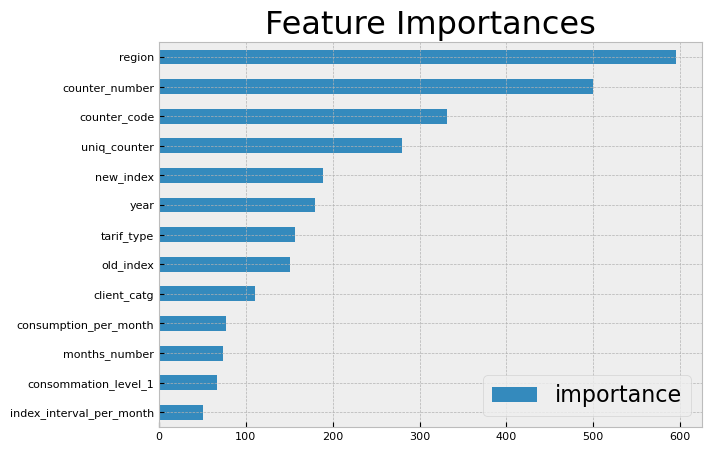

In [105]:
# plot feature importance
feature_importances = feature_importances.sort_values('importance', ascending=True)
feature_importances[feature_importances['importance'] > 30].plot(kind='barh', title='Feature Importances', style='bmh', fontsize=8, figsize=(7, 5))

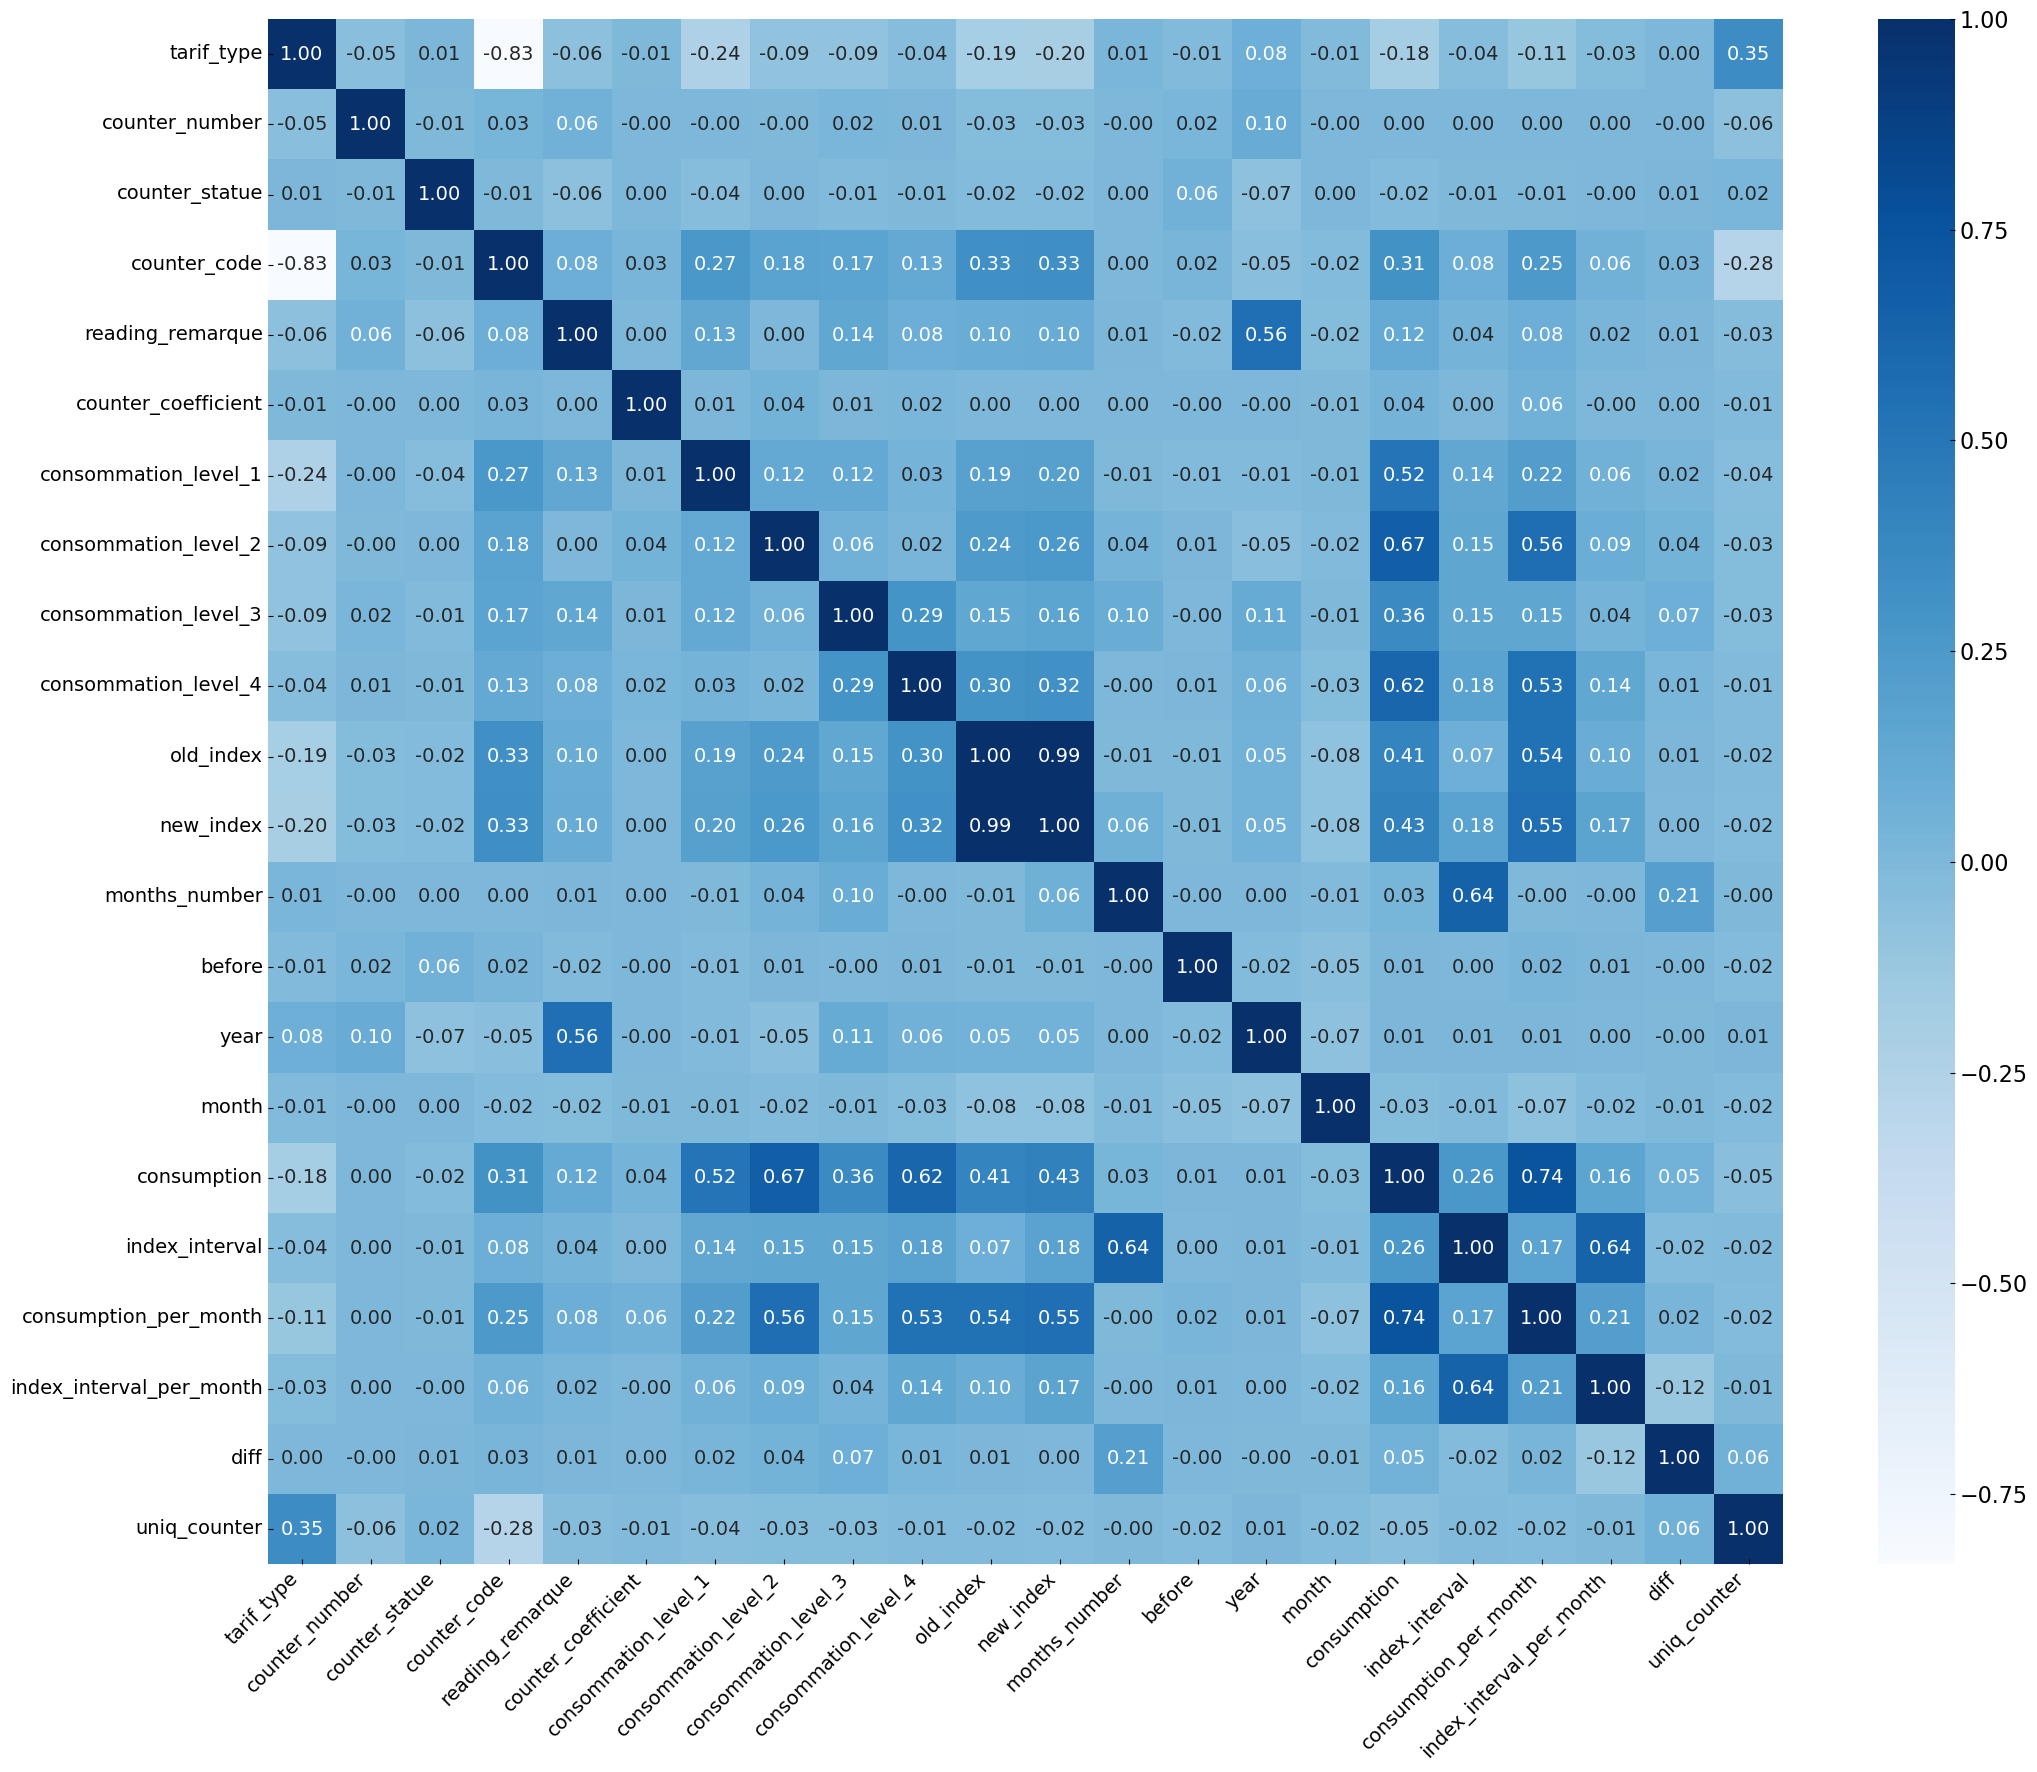

In [106]:
# don't include the categorical features
sub_X = X.drop(cat_fs, axis=1)
# calculate the correlation matrix
corr_m = sub_X.corr()
# plot the correlation matrix
plt.style.use('bmh')
plt.figure(figsize=(22, 18))
#plt.rcParams['font.size'] = 8
plt.grid(False)
sns.heatmap(corr_m, annot=True, 
            #linewidths=0.01, 
            annot_kws={'size': 14},
            fmt='.2f', 
            cmap='Blues')

plt.tick_params(axis='both', labelsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(ha='right')

plt.tight_layout()

From the result of the feature importance and the correlation heatmap, I would exclude 'old_index' and 'tarif_type' in the following modelling. Since they have the same value of feature importance and are highly correlated with 'new_index' and 'counter_code'.

In [107]:
X_train = X_train.drop(['old_index', 'tarif_type'], axis=1) 
X_test = X_test.drop(['old_index', 'tarif_type'], axis=1)
X_train.shape, X_test.shape

((3581370, 24), (895343, 24))

------- Model: LGBM_1_drop -------
ROC AUC:  0.7316750893798911
Classification Report: 
               precision    recall  f1-score   support

         0.0      0.957     0.704     0.811    824806
         1.0      0.154     0.630     0.247     70537

    accuracy                          0.698    895343
   macro avg      0.555     0.667     0.529    895343
weighted avg      0.894     0.698     0.767    895343

Confusion Matrix: 
 [[580439 244367]
 [ 26117  44420]]
Confusion Matrix (Normalized): 
 [[0.70372791 0.29627209]
 [0.37025958 0.62974042]]


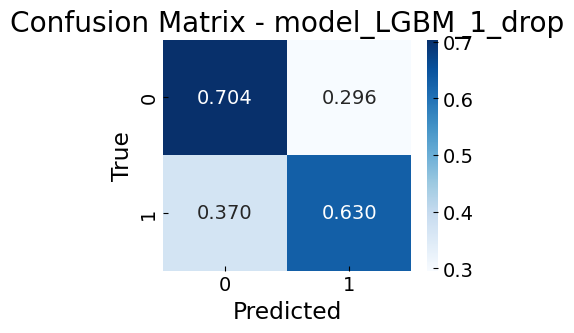

In [108]:
# inspect how will it affect the confusion matrix and the roc curve if I drop the old_index

lgbm = LGBMClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=SEED, verbose=-1)
lgbm.fit(X_train, y_train, categorical_feature=cat_fs)

y_pred = lgbm.predict(X_test)  
y_pred_proba = lgbm.predict_proba(X_test)[:,1]

metp.scores_and_matrix('LGBM_1_drop', y_test, y_pred, y_pred_proba)


compare the result from model_lgbm_1, it doesn't change much, therefore it's fine to drop 'old_index' and 'tarif_type'.

p.s. in the final model, the features to be dropped will differ. I will do feature selection again for the new set of features.

# **Model_LGBM_2**
add uniq_counter_num

### **counter_number, uniq_counter_num**

In [109]:
# inspect how many unique 'counter_number' in each client_id
df.query('client_id == "train_Client_100083"')[['counter_number', 'target']].nunique()

counter_number    2
target            1
dtype: int64

In [110]:
# create a new column to record the number of unique 'counter_number' in each client_id
df['uniq_counter_num'] = df.groupby('client_id')['counter_number'].transform('nunique')
# check if the new column is correct
print(df.query('client_id == "train_Client_100083"').uniq_counter_num[:1])

2977    2
Name: uniq_counter_num, dtype: int64


The table means the number and the ratio of non-fraudulent and fraudulent cases for each feature value.
target              0.0   1.0   ratio_0   ratio_1
uniq_counter_num                                 
1.0               62169  1308  0.979394  0.020606
2.0               49926  3297  0.938053  0.061947
3.0               13138  2281  0.852066  0.147934
4.0                2293   590  0.795352  0.204648
5.0                 340    74  0.821256  0.178744
6.0                  51    16  0.761194  0.238806
7.0                   6     0  1.000000  0.000000
8.0                   3     0  1.000000  0.000000



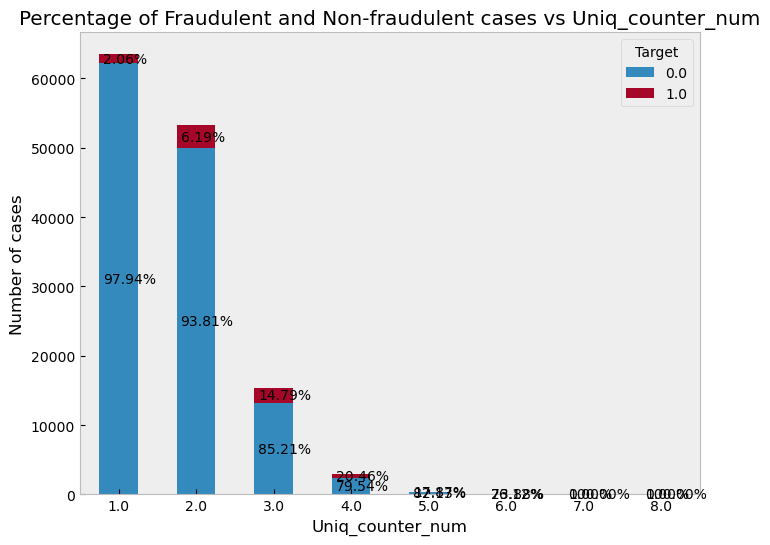

The highest rate of fraudulent is uniq_counter_num = 6.0 with rate 23.88%
The second highest rate of fraudulent is tarif_type = 4.0 with rate 20.46%
The third highest rate of fraudulent is tarif_type = 5.0 with rate 17.87%


In [111]:
# plot distribution of target cases vs uniq_counter_num
agg_df = df.groupby('client_id')[['uniq_counter_num', 'target']].mean()

# plot distribution of target cases vs uniq_counter_num
edap.feature_target_distribution(agg_df, 'uniq_counter_num', 'target')

### **save new dataframe**

In [112]:
# save the dataframe for model_2
df.to_csv('processed_data/df_2_uniq_num.csv', index=False)

### **Modeling**

In [113]:
from sklearn.model_selection import train_test_split

SEED = 2004

# features to drop
drop_fs = ['client_id', 'creation_date', 'invoice_date', 'target', 'old_index', 'tarif_type']

# set up X and y
y = df['target']
X = df.drop(drop_fs, axis=1)

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3581370, 25), (895343, 25), (3581370,), (895343,))

------- Model: LGBM_2 -------
ROC AUC:  0.828965267061994
Classification Report: 
               precision    recall  f1-score   support

         0.0      0.976     0.709     0.822    824806
         1.0      0.190     0.797     0.307     70537

    accuracy                          0.716    895343
   macro avg      0.583     0.753     0.564    895343
weighted avg      0.914     0.716     0.781    895343

Confusion Matrix: 
 [[584950 239856]
 [ 14291  56246]]
Confusion Matrix (Normalized): 
 [[0.70919707 0.29080293]
 [0.20260289 0.79739711]]


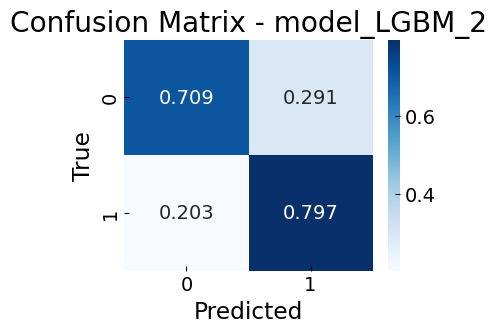

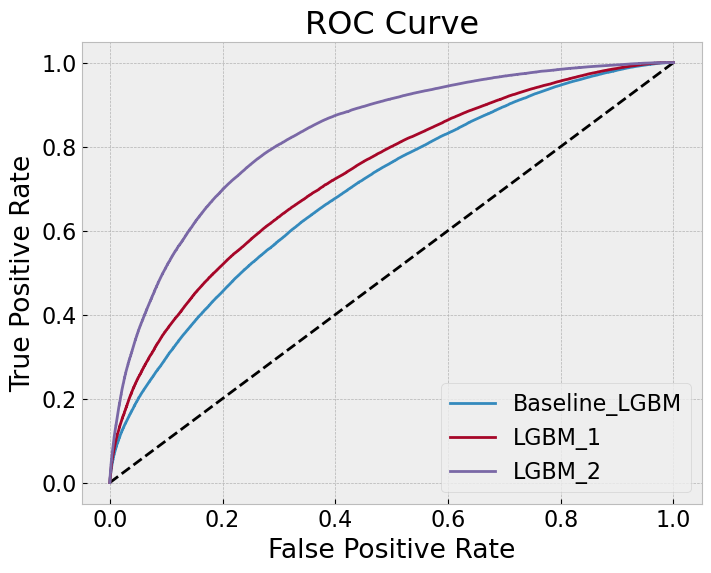

In [114]:
lgbm = LGBMClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=SEED, verbose=-1)
lgbm.fit(X_train, y_train, categorical_feature=cat_fs)

y_pred = lgbm.predict(X_test)  
y_pred_proba = lgbm.predict_proba(X_test)[:,1]

roc_curve_list += [('LGBM_2', y_test, y_pred, y_pred_proba)]
metp.scores_and_matrix('LGBM_2', y_test, y_pred, y_pred_proba)
metp.all_roc_curves(roc_curve_list)

# **Model_LGBM_3**
aggregation by client_id, get statistical values

In [115]:
df.columns

Index(['client_id', 'creation_date', 'district', 'region', 'client_catg',
       'target', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type', 'before', 'year', 'month',
       'consumption', 'index_interval', 'consumption_per_month',
       'index_interval_per_month', 'diff', 'uniq_counter', 'uniq_counter_num'],
      dtype='object')

### **clients dataframe**

In [116]:
# get clients dataframe
df_agg = df.groupby('client_id').agg({'district': 'mean', 'region': 'mean', 'client_catg': 'mean', 'target': 'mean'}).reset_index()
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135492 entries, 0 to 135491
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   client_id    135492 non-null  object 
 1   district     135492 non-null  float64
 2   region       135492 non-null  float64
 3   client_catg  135492 non-null  float64
 4   target       135492 non-null  float64
dtypes: float64(4), object(1)
memory usage: 5.2+ MB


### **transactions_count**

In [117]:
transactions_count = df.groupby('client_id').size()
df_agg['transactions_count'] = transactions_count.values

### **categorical featurs**

In [118]:
# counter_code and counter_number are already dealt with previously, therefore I will not include it here
# calculate aggregation statistics for categorical features
cat_fs = ['tarif_type', 'counter_statue', 'reading_remarque', 'counter_coefficient', 'counter_type', 'year', 'month', 'before']
for f in cat_fs:
    counts = df.groupby(['client_id', f]).size().unstack(fill_value=0)
    counts.columns = [f'{f}_count_{c}' for c in counts.columns]
    df_agg = df_agg.merge(counts, how='left', on='client_id')
    uniq_count = df.groupby('client_id')[f].nunique().rename(f'{f}_uniq_count')
    df_agg = df_agg.merge(uniq_count, how='left', on='client_id')

df_agg.shape

(135492, 118)

In [119]:
# check if the result is fine, no Nan value
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135492 entries, 0 to 135491
Columns: 118 entries, client_id to before_uniq_count
dtypes: float64(4), int64(113), object(1)
memory usage: 122.0+ MB


In [120]:
# add back the uniq_counter and uniq_counter_num
rest_fs = ['uniq_counter', 'uniq_counter_num']
df_agg = df_agg.merge(df.groupby('client_id')[rest_fs+cat_fs].mean(), how='left', on='client_id')
df_agg.shape

(135492, 128)

In [121]:
df_agg[cat_fs].head()

,tarif_type,counter_statue,reading_remarque,counter_coefficient,counter_type,year,month,before
0,11.0,0.0,6.971429,1.0,0.0,2011.142857,6.685714,0.0
1,11.0,0.0,7.216216,1.0,0.0,2011.837838,5.135135,0.0
2,11.0,0.0,7.055556,1.0,0.0,2010.944444,6.611111,0.0
3,11.0,0.0,6.150000,1.0,0.0,2008.600000,5.550000,0.0
4,11.0,0.0,8.857143,1.0,0.0,2016.857143,7.571429,0.0


In [122]:
df_agg.columns

Index(['client_id', 'district', 'region', 'client_catg', 'target',
       'transactions_count', 'tarif_type_count_8', 'tarif_type_count_9',
       'tarif_type_count_10', 'tarif_type_count_11',
       ...
       'uniq_counter', 'uniq_counter_num', 'tarif_type', 'counter_statue',
       'reading_remarque', 'counter_coefficient', 'counter_type', 'year',
       'month', 'before'],
      dtype='object', length=128)

### **numerical features**

In [123]:
# list of numeric features
num_fs = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 
          'new_index', 'months_number', 'consumption', 'index_interval','diff', 'consumption_per_month', 'index_interval_per_month']

# list of aggregation functions
agg_funcs = ['mean', 'std', 'min', 'max', 'sum', 'median', 'skew'] # , 'kurtosis'

# calculate aggregation statistics for numeric features
df_agg_num = df.groupby('client_id')[num_fs].agg(agg_funcs).reset_index()

# rename the columns
df_agg_num.columns = ['_'.join(filter(None, col_func)) for col_func in df_agg_num.columns]


In [140]:
# df_agg_num.columns

In [125]:
# merge the two dataframes
df_agg = df_agg.merge(df_agg_num, how='left', on='client_id')
df_agg.shape

(135492, 205)

In [126]:
# save the whole dataframe
df_agg.to_csv('processed_data/df_3_agg.csv', index=False)

## **Modeling**

In [127]:
df = pd.read_csv('processed_data/df_3_agg.csv')
df.shape

(135492, 205)

In [128]:
from sklearn.model_selection import train_test_split
SEED = 2004

# set up X and y
y = df['target']
X = df.drop(['target', 'client_id'], axis=1)

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((108393, 203), (27099, 203), (108393,), (27099,))

In [129]:
# cat_fs = ['tarif_type', 'counter_statue', 'reading_remarque', 'counter_coefficient', 'counter_type', 'year', 'month', 'before']

------- Model: LGBM_3 -------
ROC AUC:  0.8866543876627229
Classification Report: 
               precision    recall  f1-score   support

         0.0      0.984     0.825     0.898     25544
         1.0      0.215     0.785     0.337      1555

    accuracy                          0.823     27099
   macro avg      0.600     0.805     0.618     27099
weighted avg      0.940     0.823     0.866     27099

Confusion Matrix: 
 [[21086  4458]
 [  335  1220]]
Confusion Matrix (Normalized): 
 [[0.82547761 0.17452239]
 [0.21543408 0.78456592]]


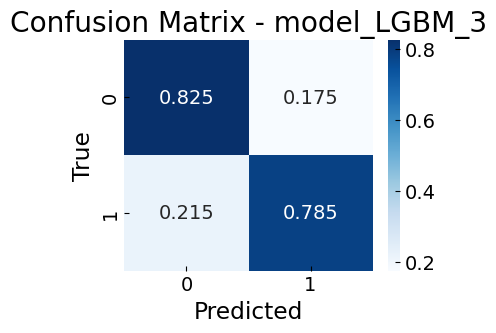

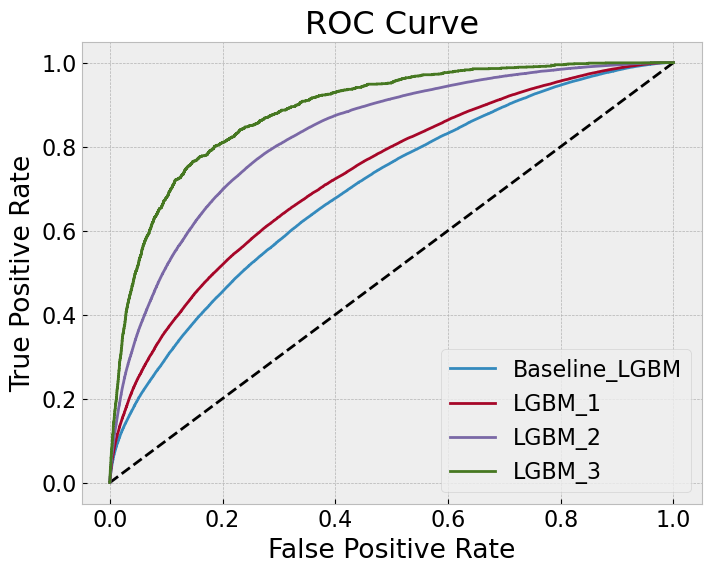

In [130]:
lgbm = LGBMClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=SEED, verbose=-1)
lgbm.fit(X_train, y_train, categorical_feature=cat_fs)

y_pred = lgbm.predict(X_test)  
y_pred_proba = lgbm.predict_proba(X_test)[:,1]

roc_curve_list += [('LGBM_3', y_test, y_pred, y_pred_proba)]
metp.scores_and_matrix('LGBM_3', y_test, y_pred, y_pred_proba)
metp.all_roc_curves(roc_curve_list)

# **Model_LGBM_4**
- select features by feature importance and correlation
- avoid overfitting

### **feature importance and correlation**

In [131]:
# calculate the feature importance
feature_importances = pd.DataFrame(lgbm.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                              importance
uniq_counter_num                     147
region                               140
tarif_type                           116
year                                  96
uniq_counter                          91
...                                  ...
counter_coefficient_count_33           0
counter_type                           0
counter_coefficient                    0
counter_statue                         0
year_count_1990                        0

[203 rows x 1 columns]


<Axes: title={'center': 'Feature Importances'}>

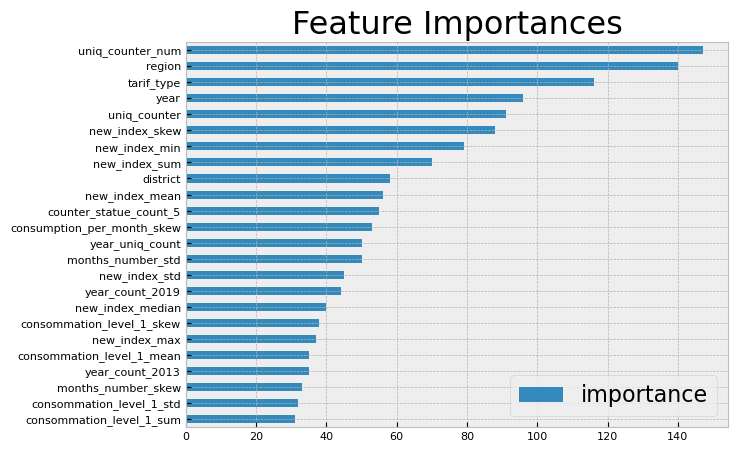

In [132]:
# plot feature importance
feature_importances = feature_importances.sort_values('importance', ascending=True)
feature_importances[feature_importances['importance'] > 30].plot(kind='barh', title='Feature Importances', style='bmh', fontsize=8, figsize=(7, 5))

In [133]:
# # don't include the categorical features
# sub_X = X.drop(cat_fs, axis=1)
# # calculate the correlation matrix
# corr_m = sub_X.corr()

# # filter absolute value of correlation bigger than 0.8 and remove the diagonal
# high_corr = (abs(corr_m) >= 0.8) & (np.eye(len(corr_m)) == 0)

# # new correlation matrix
# filtered_corr_m = corr_m[high_corr]

# # plot
# plt.style.use('bmh')
# plt.figure(figsize=(22, 18))
# sns.heatmap(filtered_corr_m, annot=True, annot_kws={'size': 14}, fmt='.2f', cmap='Blues')
# plt.tick_params(axis='both', labelsize=14)
# plt.xticks(rotation=45, ha='right')
# plt.yticks(ha='right')
# plt.tight_layout()

# # this plot is difficult to read, so it's not worth to plot it


In [134]:
# dictionary of feature importance
fi = feature_importances.to_dict()['importance']

# sub_dataframe without categorical features
sub_X = X.drop(cat_fs, axis=1)
# calculate the correlation matrix
corr_m = sub_X.corr()
# initialize a set to store the features to drop
drop_list = set()
# loop over the matrix columns
# filter the absolute value of correlation bigger than 0.8
# compare the feature importance of the two features, drop the one with smaller importance
for i in range(len(corr_m.columns)):
    for j in range(i):
        if abs(corr_m.iloc[i, j]) > 0.8:
            feature1 = corr_m.columns[i]
            feature2 = corr_m.columns[j]
            if fi[feature1] < fi[feature2]:
                drop_list.add(feature1)
            else:
                drop_list.add(feature2)

# transform the set to list
drop_list = list(drop_list)
print(len(drop_list))
print(drop_list)

60
['months_number_mean', 'consommation_level_1_min', 'index_interval_per_month_max', 'year_count_2015', 'counter_type_count_0', 'consommation_level_3_median', 'consumption_per_month_std', 'year_count_2016', 'reading_remarque_count_5', 'diff_min', 'counter_coefficient_count_1', 'months_number_min', 'index_interval_per_month_sum', 'counter_statue_count_0', 'year_count_2014', 'consommation_level_4_std', 'index_interval_per_month_mean', 'before_count_0', 'year_count_2012', 'tarif_type_count_13', 'year_count_2008', 'counter_type_uniq_count', 'consommation_level_4_median', 'year_count_2009', 'year_count_2017', 'tarif_type_count_14', 'transactions_count', 'new_index_max', 'diff_max', 'consumption_mean', 'consommation_level_2_mean', 'months_number_median', 'consommation_level_2_sum', 'index_interval_min', 'index_interval_per_month_skew', 'consommation_level_1_max', 'counter_type_count_1', 'consommation_level_1_median', 'consumption_max', 'year_count_2007', 'consommation_level_3_max', 'months_

In [135]:
X_fs = X.drop(drop_list, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((108393, 143), (27099, 143), (108393,), (27099,))

------- Model: LGBM_4 -------
ROC AUC:  0.8860252985076882
Classification Report: 
               precision    recall  f1-score   support

         0.0      0.984     0.826     0.898     25544
         1.0      0.215     0.784     0.338      1555

    accuracy                          0.823     27099
   macro avg      0.600     0.805     0.618     27099
weighted avg      0.940     0.823     0.866     27099

Confusion Matrix: 
 [[21095  4449]
 [  336  1219]]
Confusion Matrix (Normalized): 
 [[0.82582994 0.17417006]
 [0.21607717 0.78392283]]


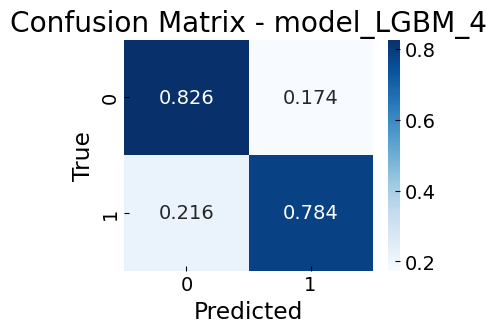

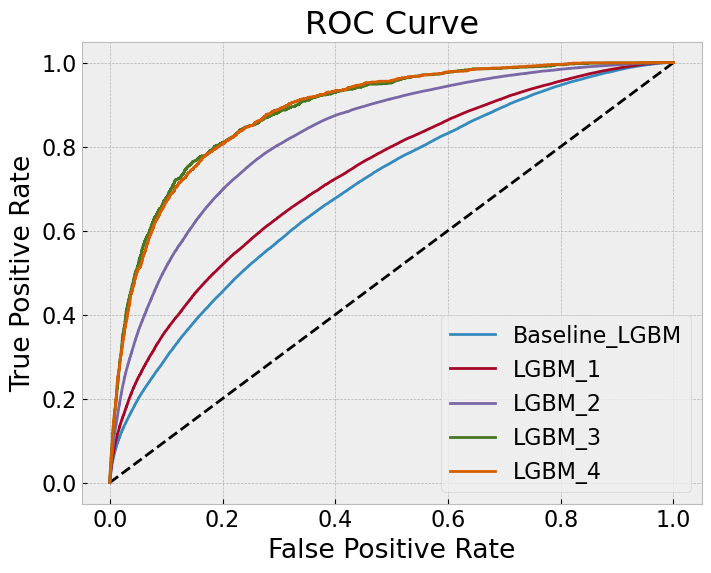

In [136]:
lgbm = LGBMClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=SEED, verbose=-1)
lgbm.fit(X_train, y_train, categorical_feature=cat_fs)

y_pred = lgbm.predict(X_test)  
y_pred_proba = lgbm.predict_proba(X_test)[:,1]

roc_curve_list += [('LGBM_4', y_test, y_pred, y_pred_proba)]
metp.scores_and_matrix('LGBM_4', y_test, y_pred, y_pred_proba)
metp.all_roc_curves(roc_curve_list)

after selection by feature importance and correlation, the result is almost the same and can avoid overfiting.

In [137]:
from joblib import dump

# save the model
dump(lgbm, 'models/lgbm_4.joblib')

['models/lgbm_4.joblib']

# **Model_LGBM_5**
hyperparameters tunning

## **Bayesian Optimization**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
import numpy as np


SEED = 2004

# set the parameter boundaries
param_bounds = {
    'n_estimators': (50, 1300),
    'max_depth': (1, 30),
    'learning_rate': (0.0001, 0.1),
    'num_leaves': (10, 100),
    'min_child_samples': (5, 50),
    'feature_fraction': (0.1, 1.0),
    'bagging_fraction': (0.1, 1.0)
}

# define the function to optimize
def lgbm_cv_score(n_estimators, max_depth, learning_rate, num_leaves, min_child_samples, feature_fraction, bagging_fraction):
    model = LGBMClassifier(
        n_estimators=int(round(n_estimators)),
        max_depth=int(round(max_depth)),
        learning_rate=learning_rate,
        num_leaves=int(round(num_leaves)),
        min_child_samples=int(round(min_child_samples)),
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        random_state=SEED,
        class_weight='balanced',
        verbose=-1
    )
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    return np.mean(scores)


# define the optimizer
optimizer = BayesianOptimization(
    f=lgbm_cv_score,
    pbounds=param_bounds,
    random_state=SEED,
    verbose=1
)

# execute optimization
optimizer.maximize(init_points=10, n_iter=60)

# get the best parameters
best_params = optimizer.max['params']

# record the result
print(best_params)


|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------
| 2         | 0.8774    | 0.9748    | 0.6069    | 0.007211  | 13.15     | 24.92     | 665.8     | 22.97     |
| 7         | 0.8781    | 0.1484    | 0.8291    | 0.01952   | 4.969     | 36.15     | 1.115e+03 | 73.4      |
| 15        | 0.8802    | 0.1348    | 0.8674    | 0.02675   | 25.78     | 49.64     | 221.8     | 34.92     |
| 16        | 0.8808    | 0.4449    | 0.2995    | 0.02463   | 17.24     | 25.48     | 663.1     | 21.49     |
| 21        | 0.8812    | 0.6325    | 0.6837    | 0.02141   | 16.7      | 31.88     | 665.6     | 20.96     |
{'bagging_fraction': 0.6324668680846927, 'feature_fraction': 0.6837393912257999, 'learning_rate': 0.021405123027731367, 'max_depth': 16.697149293508705, 'min_child_samples': 31.877930126444, 'n_estimators': 665.5630146641006, 'num

------- Model: LGBM_5 -------
ROC AUC:  0.8888866118911647
Classification Report: 
               precision    recall  f1-score   support

         0.0      0.984     0.831     0.901     25544
         1.0      0.219     0.782     0.343      1555

    accuracy                          0.828     27099
   macro avg      0.602     0.806     0.622     27099
weighted avg      0.940     0.828     0.869     27099

Confusion Matrix: 
 [[21217  4327]
 [  339  1216]]
Confusion Matrix (Normalized): 
 [[0.83060601 0.16939399]
 [0.21800643 0.78199357]]


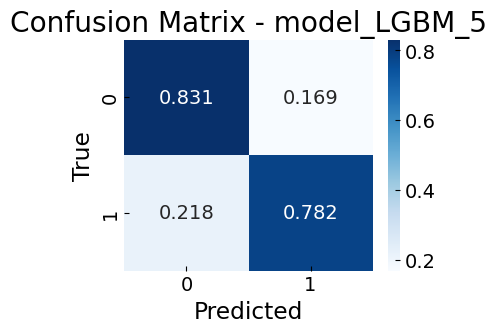

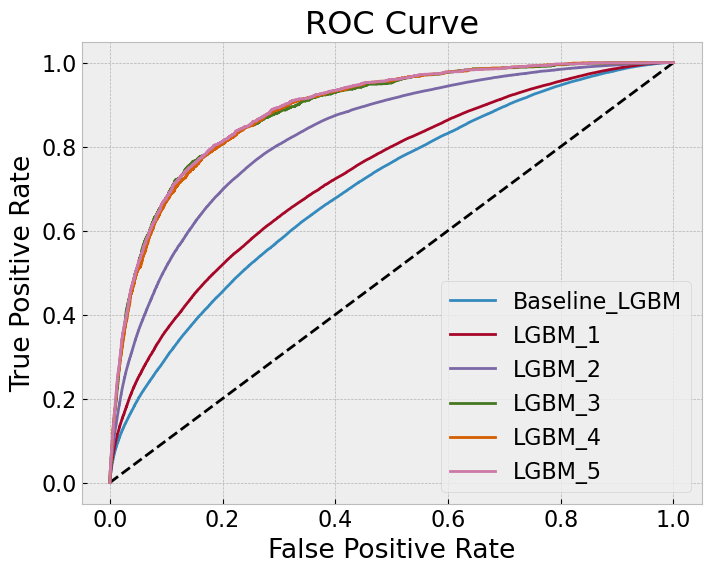

In [139]:
# the best parameters found so far
# best_params = {'bagging_fraction': 0.6324668680846927, 'feature_fraction': 0.6837393912257999, 'learning_rate': 0.021405123027731367, 'max_depth': 16.697149293508705, 'min_child_samples': 31.877930126444, 'n_estimators': 665.5630146641006, 'num_leaves': 20.960144113583453}

# convert float parameters to int
best_n_estimators = int(round(best_params['n_estimators']))
best_max_depth = int(round(best_params['max_depth']))
best_learning_rate = best_params['learning_rate']
best_num_leaves = int(round(best_params['num_leaves']))
best_min_child_samples = int(round(best_params['min_child_samples']))
best_feature_fraction = best_params['feature_fraction']
best_bagging_fraction = best_params['bagging_fraction']

# build the model with the best parameters
best_lgbm = LGBMClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    num_leaves=best_num_leaves,
    min_child_samples=best_min_child_samples,
    feature_fraction=best_feature_fraction,
    bagging_fraction=best_bagging_fraction,
    random_state=SEED,
    class_weight='balanced',
    verbose=-1
)
best_lgbm.fit(X_train, y_train, categorical_feature=cat_fs)

# predict on test data
y_pred = best_lgbm.predict(X_test)  
y_pred_proba = best_lgbm.predict_proba(X_test)[:,1]

# append the data to the list
roc_curve_list += [('LGBM_5', y_test, y_pred, y_pred_proba)]
# calculate the metrics and plot the confusion matrix
metp.scores_and_matrix('LGBM_5', y_test, y_pred, y_pred_proba)
# plot the ROC curve
metp.all_roc_curves(roc_curve_list)

## **Summary**

- In the original dataset, features such as 'region', 'counter_number', 'counter_code', 'new_index', 'old_index', and 'tarif_type' have a significant impact on the prediction model.

- Introducing new features like 'uniq_counter' and 'uniq_counter_num' evidently enhances the model's performance.

- Feature selection based on calculating feature importance and correlation is an effective strategy to prevent overfitting without compromising model performance.

- Statistical values derived from categorical and numerical featues substantially improve the model's accuracy.

- Hyperparameter tuning using Bayesian optimization can identify an improved set of parameters, leading to a slight enhancement in model efficacy.